In [1]:
%matplotlib inline
from glob import glob
from pandas import DataFrame, read_csv, Series, to_datetime
from pickle import dump, load
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from random import randint 
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def comma(number): return "{:,}".format(number)
def scolor(i,n,pickColor): 
    scalar = 255 - int((i/float(n))*120) 
    if pickColor: return '#%02X%02X%02X' % (128,scalar,128)
    return '#%02X%02X%02X' % (75,scalar,200)

<h1><a id='outline'>Project Outline</a></h1>

* [Metadata](#meta)
* [Sequencing Overview](#analysis)
    *  [Contig Occupency](#occon)
*  [NMDS of annotated contigs](#nmds)
  *  [All Crops](#anmds)
  *  [Switchgrass](#sgnmds)
  *  [Miscanthus](#msnmds)
*  [Function Analysis](#metaT)


<h2><a id="meta">GLBRC Metadata</a></h2>

In [2]:
metadata = read_csv("metadata/GLBRC_MetaG_Metadata.tsv",sep='\t')
metadata.set_index("nucleic_acid_name",inplace=True)
metadata.drop(["source","sampling ID","sequencing_type","height_mean_cm","air_temp_c"],axis=1,inplace=True)

for id in metadata.index: metadata.loc[id,"type"] = metadata[metadata.index == id].plot_name[0][0:2]
metadata['Date'] = to_datetime(metadata.sampling_date)
metadata=metadata.sort_values(by=["type","Date","treatment","plot_name"])
# metadata['JGI_File'] = metadata.index
metadata.head()

,reads_file_name,treatment,plot_name,rep,sampling_date,Sampling Time,type,Date
nucleic_acid_name,,,,,,,,
G5R1_NF_09MAY2016_LD1,11425.5.206700.GCCTTGT-AACAAGG.fastq.gz,nitrogen free,G5R1_NF,1,5/9/16,12:00,G5,2016-05-09
G5R2_NF_09MAY2016_LD1,11425.5.206700.CTGACAC-TGTGTCA.fastq.gz,nitrogen free,G5R2_NF,2,5/9/16,14:43,G5,2016-05-09
G5R3_NF_09MAY2016_LD1,11425.3.206650.CCAGTGT-AACACTG.fastq.gz,nitrogen free,G5R3_NF,3,5/9/16,15:26,G5,2016-05-09
G5R4_NF_09MAY2016_LD1,11425.5.206700.TGTACAC-GGTGTAC.fastq.gz,nitrogen free,G5R4_NF,4,5/9/16,13:56,G5,2016-05-09
G5R1_MAIN_09MAY2016_LD1,11425.3.206650.GAGCTCA-TTGAGCT.fastq.gz,standard fertilization,G5R1_MAIN,1,5/9/16,12:00,G5,2016-05-09


# Creating links to the raw data files from JGI

In [3]:
from os import listdir, path, system
rawFiles = {}
baseDir = "/mnt/research/ShadeLab/Sequence/raw_sequence/GLBRC/metagenomes/"
dirs = listdir(baseDir)
for dirName in dirs:
    rawDir = path.join(baseDir,dirName,"Raw_Data/")
    fastq = listdir(rawDir)[0]
    rawFiles[fastq] = path.join(rawDir,fastq)
metaGUnpaired = "/mnt/research/ShadeLab/GLBRC/mapping/metaG/unpaired/%s.fastq.gz"
    
for readFName,row in metadata.iterrows():
    if readFName not in rawFiles:
        print("No fastq for "+readFileName)
        continue
    system("ln -s %s %s" % (rawFiles[readFName],metaGUnpaired %(row.loc['nucleic_acid_name'])))

<h2><a id="analysis">Sequence Mapping Overview</a></h2>
<h4>Host organism reads removal</h4>

In [18]:
hostMapping = read_csv("mapping/metaG/hostRemoval/multiqc_bowtie2.txt",sep='\t')
hostMapping.set_index("Sample",inplace=True)
hostMapping['type'] = ""
for id in hostMapping.index: hostMapping.at[id,"type"] = id[0:2]
hostMapping["sample_name"]=""
for id in hostMapping.index: hostMapping.at[id,"sample_name"] = id.replace(".stat","")
hostMapping.set_index("sample_name",inplace=True)
hostMapping.head()

,total_reads,paired_total,paired_aligned_none,paired_aligned_one,paired_aligned_multi,paired_aligned_discord_one,paired_aligned_mate_none,paired_aligned_mate_one,paired_aligned_mate_multi,overall_alignment_rate,paired_aligned_mate_multi_halved,paired_aligned_mate_none_halved,paired_aligned_mate_one_halved,type
Sample,,,,,,,,,,,,,,
G5R1_MAIN_01AUG2016_LD1.stat,5975345,5924069,1456152,1445666,3022251,33663,2084849,256653,503476,82.40,251738.0,1042424.5,128326.5,G5
G5R1_MAIN_03OCT2016_LD1.stat,8615788,8528146,6957303,457799,1113044,9540,13668862,73292,153372,19.82,76686.0,6834431.0,36646.0,G5
G5R1_MAIN_09MAY2016_LD1.stat,6888824,6828883,2222145,1508784,3097954,36624,3624079,268840,478123,73.46,239061.5,1812039.5,134420.0,G5
G5R1_MAIN_12JUL2016_LD1.stat,10182583,10042351,2022000,2594162,5426189,68503,2384468,495577,1026949,88.09,513474.5,1192234.0,247788.5,G5
G5R1_MAIN_12SEP2016_LD1.stat,8024208,7957864,4843759,1002139,2111966,18921,9179491,168248,301937,42.27,150968.5,4589745.5,84124.0,G5


In [26]:
SGData = hostMapping[hostMapping['type']=='G5']
MiscanData = hostMapping[hostMapping['type']=='G6']

sgTotal = SGData['total_reads'].sum()
miscanTotatl = MiscanData['total_reads'].sum()

sgBact = SGData['paired_aligned_none'].sum()
miscanBact = MiscanData['paired_aligned_none'].sum()

(sgTotal-sgBact)/sgTotal*100

(miscanTotatl-miscanBact)/miscanTotatl*100

comma(SGData['paired_aligned_none'].sum() +MiscanData['paired_aligned_none'].sum())

#### Alignment of non-host related reads to metagenomic assembly

In [6]:
seqMapping = read_csv("mapping/metaG/fullAssembly/multiqc_data/multiqc_bowtie2.txt",sep='\t')
seqMapping.set_index("Sample",inplace=True)
seqMapping['type'] = ""
for id in seqMapping.index: seqMapping.at[id,"type"] = id[0:2]
seqMapping["sample_name"]=""
for id in seqMapping.index: seqMapping.at[id,"sample_name"] = id.replace(".stat","")
seqMapping.set_index("sample_name",inplace=True)
seqMapping.head()

,total_reads,paired_total,paired_aligned_none,paired_aligned_one,paired_aligned_multi,paired_aligned_discord_one,paired_aligned_mate_none,paired_aligned_mate_one,paired_aligned_mate_multi,overall_alignment_rate,paired_aligned_mate_multi_halved,paired_aligned_mate_none_halved,paired_aligned_mate_one_halved,type
sample_name,,,,,,,,,,,,,,
G5R1_MAIN_01AUG2016_LD1,801996,801996,236096,393846,172054,12008,332039,46895,69242,79.30,34621.0,166019.5,23447.5,G5
G5R1_MAIN_03OCT2016_LD1,6753815,6753815,1176079,3127763,2449973,60231,1623641,208720,399335,87.98,199667.5,811820.5,104360.0,G5
G5R1_MAIN_09MAY2016_LD1,1572819,1572819,428877,376661,767281,13648,507423,90724,232311,83.87,116155.5,253711.5,45362.0,G5
G5R1_MAIN_12JUL2016_LD1,729303,729303,191014,368352,169937,12991,218236,56798,81012,85.04,40506.0,109118.0,28399.0,G5
G5R1_MAIN_12SEP2016_LD1,4427118,4427118,815340,2046133,1565645,41191,1014794,173568,359936,88.54,179968.0,507397.0,86784.0,G5


In [9]:
SGData = seqMapping[hostMapping['type']=='G5']
MiscanData = seqMapping[hostMapping['type']=='G6']

sgTotal = SGData['total_reads'].sum()
miscanTotatl = MiscanData['total_reads'].sum()

sgBact = SGData['paired_aligned_none'].sum()
miscanBact = MiscanData['paired_aligned_none'].sum()

print('SG %% aligned: %.2f' % ((sgTotal-sgBact)/sgTotal*100),comma(sgTotal))
print('Miscanthus %% aligned: %.2f' % ((miscanTotatl-miscanBact)/miscanTotatl*100),comma(miscanTotatl))
print(comma(SGData['paired_aligned_none'].sum() +MiscanData['paired_aligned_none'].sum()))

#MetaG
metaG = read_csv("mapping/metaG/annotatedContigs/logs/multiqc_data/mqc_trimmomatic_plot_1.txt",sep="\t")
metaG.set_index('Sample',inplace=True)
print(comma(metaG['Surviving Reads'].sum()))

metaT = read_csv("mapping/metaT/fullAssembly/logs/multiqc_data/multiqc_trimmomatic.txt",sep="\t")
metaT.set_index('Sample',inplace=True)
print(comma(metaT['surviving'].sum())

metaT['Base'],metaG['Base'] = '',''

for sampleID in metaG.index:
    metaG.at[sampleID,'Base'] = sampleID[:sampleID.rfind('_')]
for sampleID in metaT.index:
    metaT.at[sampleID,'Base'] = sampleID[:sampleID.rfind('_')]

metaT.set_index("Base",inplace=True)
metaG.set_index("Base",inplace=True)

comma(metaT['surviving'].sum()-metaG['Surviving Reads'].sum())

In [3]:
# for sampleID in ids.intersection(ids2):
#     print(sampleID,'\t',comma(int(metaT.at[sampleID,'surviving'])),'\t',comma(int(metaG.at[sampleID,'Surviving Reads'])))

In [ ]:
data = read_csv("mapping/metaG/annotatedContigs/logs/multiqc_data/mqc_bowtie2_pe_plot_1.txt",sep="\t")
data["TotalSampleReads"] = data.sum(axis=1)
#data[["PE mapped uniquely","PE mapped discordantly uniquely","PE multimapped"]]/data["TotalSampleReads"] 
print("(%i, %i)" % (data.shape, metadata.shape))
data.head()

# KEGG Annotations

In [3]:
annotation_hierarchy = read_csv("annotations/KeggAnnotationTable_filtered.tsv",sep='\t')
annotation_hierarchy["EC#"] = ""
for i in annotation_hierarchy.index:
    function = annotation_hierarchy.at[i,'function']
    ecNumIndex = function.rfind(" [EC")
    if ecNumIndex != -1:
        annotation_hierarchy.at[i,'EC#'] = function[ecNumIndex+2:-1]
        annotation_hierarchy.at[i,'function'] = function[:ecNumIndex]
annotation_hierarchy.head(5)

# ("annotations/MetagenomicAssemblyAnnotations.txt")

,level1,level2,level3,function,id,EC#
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1
1,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],GCK; glucokinase,K12407,EC:2.7.1.2
2,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],glk; glucokinase,K00845,EC:2.7.1.2
3,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],"GPI, pgi; glucose-6-phosphate isomerase",K01810,EC:5.3.1.9
4,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],"pgi1; glucose-6-phosphate isomerase, archaeal",K06859,EC:5.3.1.9


In [4]:
ko_map = read_csv("annotations/ko/ko_genes.list",sep='\t')
ko_map.head()

,KO_NUM,GENE
0,K14021,hsa:578
1,K14018,hsa:9373
2,K04429,hsa:9344
3,K04366,hsa:5894
4,K04365,hsa:673


In [6]:
len(annotation_hierarchy.id.unique()),len(set(ko_map.KO_NUM.unique())),len(set(ko_map.KO_NUM.unique()).intersection(annotation_hierarchy.id))

(19844, 21711, 18929)

In [7]:
import pandas as pd
df = pd.merge(annotation_hierarchy, ko_map, left_on='id',right_on='KO_NUM', how='left')
df.head()

,level1,level2,level3,function,id,EC#,KO_NUM,GENE
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,hsa:3101
1,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,hsa:3098
2,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,hsa:3099
3,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,hsa:80201
4,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,ptr:462298


### Create the level 3 table

In [10]:
genes = set()
for line in open("annotations/UniqFoundGenes.txt"):
    genes.add(line.strip())
len(genes),len(genes.difference(ko_map.GENE))

(700982, 193017)

In [11]:
df[df["level3"]=="Glycolysis / Gluconeogenesis [PATH:ko00010]"]

,level1,level2,level3,function,id,EC#,KO_NUM,GENE
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,hsa:3101
1,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,hsa:3098
2,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,hsa:3099
3,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,hsa:80201
4,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,ptr:462298
5,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,ptr:450505
6,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,ptr:741291
7,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,ptr:450504
8,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,pps:100990081
9,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],HK; hexokinase,K00844,EC:2.7.1.1,K00844,pps:100983149


In [ ]:
import pandas as pd
df = pd.merge(annotation_hierarchy, ko_map, left_on='function',right_on='GENE', how='left')

In [9]:
df = read_csv("annotations/ContigsW_Annotations.txt",sep='\t')

df.head(), df.shape

(              KO                Anno
 0   k127_1000000     stax:MC45_12930
 1  k127_10000013      bos:BSY19_4235
 2  k127_10000013  maqu:Maq22A_c11310
 3  k127_10000013     mee:CS521_12005
 4  k127_10000013       met:M446_2163, (5038084, 2))

In [ ]:
def mapKOs(df):
    df['cost_cents'] = df.apply(
        lambda row: apply_tariff(
            kwh=row['energy_kwh'],
            hour=row['date_time'].hour),
        axis=1)

>>> apply_tariff_withapply(df)

In [69]:
ko_dict = {}
for row in ko_map.iterrows():
    if row[1].values[1] in ko_dict:
        print(row)
        print()
        print(ko_dict[row[1].values[1]])
        break
    ko_dict[row[1].values[1]]=row[1].values[0]


(11762, KoNum      K18200
Gene     hsa:5066
Name: 11762, dtype: object)

K00504


In [8]:
from collections import Counter
annos = Annotation()
missing = Counter()
with open("annotations/MetagenomicAssemblyAnnotations_filtered_90PID.txt","r") as fh:
    for i,line in enumerate(fh):
        if i%500000==0:print(i,end=' ')
        rec = line.strip().split("\t")
        contigID, geneID = rec[0],rec[1]
        val = ko_map.loc[ko_map["Gene"] == geneID,['KoNum']]
        try:koNum = val.values[0][0]
        except: missing[geneID] += 1
        annos[contigID] = koNum
dump(annos,open("pickles/ContigAnnotationMap.p","wb"))
dump(missing,open("pickles/NotInKO_Map.p","wb"))
len(missing)

0 

KeyboardInterrupt: 

In [7]:
from random import randint
class Annotation:
    def __init__(self):
        self.contigs = {} # ContigsName -> set of related Annotations
        self.annotations = {} # KO number -> contigs with that KO
    def __setitem__(self,key,value):
        try: self.contigs[key].append(value)
        except: self.contigs[key] = [value]
        try: self.annotations[value].append(key)
        except: self.annotations[value] = [key]
    def __getitem__(self,key): return self.contigs[key][randint(0,len(self.contigs[key]))]



# Generating the annotation fasta files

In [4]:
from Bio.SeqIO import parse, write
from Bio.SeqRecord import SeqRecord
annotatedRegions = open("assemblies/AnnotatedContigs.fa","w")
geneDescripts = open("annotations/AnnotationDescripts.bed","w")
annotations = glob("mags/final.contigs.*/*.gbk")
seqs = set()
hypoCounter = 0
for fname in annotations:
    for rec in parse(fname,'genbank'):
        for feature in rec.features:
            try:
                product = feature.qualifiers['product'][0]
                #if product == "hypothetical protein":continue
                #subSeq = rec.seq[feature.location.start:feature.location.end]
                hypoCounter += int(product == "hypothetical protein")
                geneDescripts.write("%s\t%i\t%i\t%s\n" % (rec.id,feature.location.start,feature.location.end,product))
                if rec.id in seqs: continue
                rec.seq = rec.seq.upper()
                write(rec,annotatedRegions,"fasta")
                seqs.add(rec.id)
            except:pass
annotatedRegions.close()
geneDescripts.close()

<h2><a id="occon">Calculate Abundance and occupancy of contigs in samples</a></h2>

1. G5R1_NF_09MAY2016_LD1	2. G5R2_NF_09MAY2016_LD1	3. G5R3_NF_09MAY2016_LD1	
4. G5R4_NF_09MAY2016_LD1	5. G5R1_MAIN_09MAY2016_LD1	6. G5R2_MAIN_09MAY2016_LD1	
7. G5R3_MAIN_09MAY2016_LD1	8. G5R4_MAIN_09MAY2016_LD1	9. G5R1_NF_31MAY2016_LD1	
10. G5R2_NF_31MAY2016_LD1	11. G5R3_NF_31MAY2016_LD1	12. G5R4_NF_31MAY2016_LD1	
13. G5R1_MAIN_31MAY2016_LD1	14. G5R2_MAIN_31MAY2016_LD1	15. G5R3_MAIN_31MAY2016_LD1	
16. G5R4_MAIN_31MAY2016_LD1	17. G5R1_NF_20JUN2016_LD1	18. G5R2_NF_20JUN2016_LD1	
19. G5R3_NF_20JUN2016_LD1	20. G5R4_NF_20JUN2016_LD1	21. G5R1_MAIN_20JUN2016_LD1	
22. G5R2_MAIN_20JUN2016_LD1	23. G5R3_MAIN_20JUN2016_LD1	24. G5R4_MAIN_20JUN2016_LD1	
25. G5R1_NF_12JUL2016_LD1	26. G5R2_NF_12JUL2016_LD1	27. G5R3_NF_12JUL2016_LD1	
28. G5R4_NF_12JUL2016_LD1	29. G5R1_MAIN_12JUL2016_LD1	30. G5R2_MAIN_12JUL2016_LD1	
31. G5R3_MAIN_12JUL2016_LD1	32. G5R4_MAIN_12JUL2016_LD1	33. G5R1_NF_01AUG2016_LD1	
34. G5R2_NF_01AUG2016_LD1	35. G5R3_NF_01AUG2016_LD1	36. G5R4_NF_01AUG2016_LD1	
37. G5R1_MAIN_01AUG2016_LD1	3

0

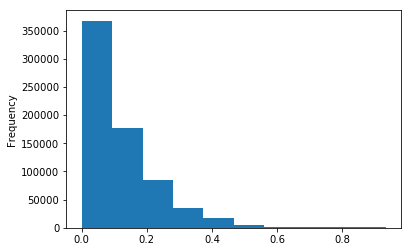

In [10]:
#Individual Sample
from collections import Counter
seqPresenceCounter, seqMappedCounter = Counter(), Counter()
missingFiles = set()
for i, statFName in enumerate(metadata.index):
    print("%i. %s" % (i,statFName),end = '\t')
    try:
        with open("mapping/metaG/stats/%s.tsv" % statFName) as fh:
            for line in fh:
                rec = line.strip().split()
                seqMappedCounter[rec[0]] += int(rec[2])
                seqPresenceCounter[rec[0]] += int(int(rec[2])>0)
        if i % 3 == 0:print()
    except:
        missingFiles.add("mapping/metaG/stats/%s.tsv" % statFName)
dump(seqPresenceCounter,open("pickles/seqPresenceCounter_genes.p","wb"))
dump(seqMappedCounter,  open("pickles/seqMappedCounter_genes.p",  "wb"))  
seqPresenceDist = Series(load(open("pickles/seqPresenceCounter_genes.p","rb")))/136.0
seqPresenceDist.plot.hist();

dump(missingFiles,open("pickles/missingFiles_genes.p","wb")) 
len(missingFiles)

In [5]:
seqPresenceCounter = load(open("pickles/seqPresenceCounter_genes.p","rb"))
smp = Series(seqPresenceCounter)
totalReads = smp.sum()
for i in range(10):
    sub = smp[smp <= i ]
    subSum = sub.sum()
    print(i,len(sub),"%.2f%%" % (len(sub)/len(smp)*100),comma(subSum),"%.2f%%" % ((subSum/totalReads)*100))
print()

0 15988 2.32% 0 0.00%
1 51005 7.39% 35,017 0.31%
2 91446 13.25% 115,899 1.04%
3 130248 18.87% 232,305 2.08%
4 165899 24.04% 374,909 3.36%
5 198234 28.72% 536,584 4.81%
6 227947 33.03% 714,862 6.41%
7 255145 36.97% 905,248 8.12%
8 280678 40.67% 1,109,512 9.96%
9 304674 44.14% 1,325,476 11.89%



# Remove anything that is in less than 5 samples

In [6]:
print("Before Number of genes:",comma(len(smp)))
keepers = set(smp[smp >= 5].index)
print("After Number of genes:",comma(len(keepers)))

Before Number of genes: 690,218
After Number of genes: 524,319


# Read the single copy number values

In [7]:
files = glob("mapping/metaG/annotatedContigs/logs/singleCopyGeneCounts/*.txt")
metadata["SingleCopyCount"] = 0.0
for fname in files:
    with open(fname) as fh:
        lines = fh.readlines()[-1].strip().split('\t')
        sampleName = fname[fname.rfind('/')+1:-4]
        metadata.at[sampleName,"SingleCopyCount"] = float(lines[-1])
metadata.head()

,treatment,plot_name,rep,sampling_date,Sampling Time,type,Date,JGI_File,SingleCopyCount
nucleic_acid_name,,,,,,,,,
G5R1_NF_09MAY2016_LD1,nitrogen free,G5R1_NF,1,5/9/16,12:00,G5,2016-05-09,11425.5.206700.GCCTTGT-AACAAGG.fastq.gz,13.848511
G5R2_NF_09MAY2016_LD1,nitrogen free,G5R2_NF,2,5/9/16,14:43,G5,2016-05-09,11425.5.206700.CTGACAC-TGTGTCA.fastq.gz,18.376013
G5R3_NF_09MAY2016_LD1,nitrogen free,G5R3_NF,3,5/9/16,15:26,G5,2016-05-09,11425.3.206650.CCAGTGT-AACACTG.fastq.gz,18.661476
G5R4_NF_09MAY2016_LD1,nitrogen free,G5R4_NF,4,5/9/16,13:56,G5,2016-05-09,11425.5.206700.TGTACAC-GGTGTAC.fastq.gz,29.482367
G5R1_MAIN_09MAY2016_LD1,standard fertilization,G5R1_MAIN,1,5/9/16,12:00,G5,2016-05-09,11425.3.206650.GAGCTCA-TTGAGCT.fastq.gz,21.415810


# Read the count numbers and normalize

In [8]:
from Bio.SeqIO import parse
readLens={}
for rec in parse("assemblies/AnnotatedContigs.fa","fasta"): readLens[rec.id] = len(rec.seq)/1000
#RPKG = (reads mapped to gene)/(gene length in kb)/(genome equivalents)
print("Number of reads: %s" % (comma(len(readLens))))

Number of reads: 4,269,227


In [9]:
readMap = {}
for line in open("mapping/metaG/stats/G5R1_NF_09MAY2016_LD1.tsv"):
    rec = line.strip().split()
    if rec[0] not in keepers:continue
    readName = rec[0][:rec[0].rfind("_")]
    readName = readName[:readName.rfind("_")]
    readMap[rec[0]] = readName

In [10]:
allCounts,counter = {},0
for sampleID in metadata.index:
    counter += 1
    print("%i. %s" % (counter,sampleID),end='\t')
    allCounts[sampleID] = {}
    for line in open("mapping/metaG/stats/%s.tsv" % sampleID):
        rec = line.strip().split()
        if rec[0] not in keepers:continue
        allCounts[sampleID][rec[0]] = float(rec[2])/readLens[readMap[rec[0]]]/metadata.at[sampleID,"SingleCopyCount"]
    if counter % 3 == 0: print()
allCounts = DataFrame(allCounts) 
dump(allCounts,open("pickles/allCounts_genes.p","wb"))  

1. G5R1_NF_09MAY2016_LD1	2. G5R2_NF_09MAY2016_LD1	3. G5R3_NF_09MAY2016_LD1	
4. G5R4_NF_09MAY2016_LD1	5. G5R1_MAIN_09MAY2016_LD1	6. G5R2_MAIN_09MAY2016_LD1	
7. G5R3_MAIN_09MAY2016_LD1	8. G5R4_MAIN_09MAY2016_LD1	9. G5R1_NF_31MAY2016_LD1	
10. G5R2_NF_31MAY2016_LD1	11. G5R3_NF_31MAY2016_LD1	12. G5R4_NF_31MAY2016_LD1	
13. G5R1_MAIN_31MAY2016_LD1	14. G5R2_MAIN_31MAY2016_LD1	15. G5R3_MAIN_31MAY2016_LD1	
16. G5R4_MAIN_31MAY2016_LD1	17. G5R1_NF_20JUN2016_LD1	18. G5R2_NF_20JUN2016_LD1	
19. G5R3_NF_20JUN2016_LD1	20. G5R4_NF_20JUN2016_LD1	21. G5R1_MAIN_20JUN2016_LD1	
22. G5R2_MAIN_20JUN2016_LD1	23. G5R3_MAIN_20JUN2016_LD1	24. G5R4_MAIN_20JUN2016_LD1	
25. G5R1_NF_12JUL2016_LD1	26. G5R2_NF_12JUL2016_LD1	27. G5R3_NF_12JUL2016_LD1	
28. G5R4_NF_12JUL2016_LD1	29. G5R1_MAIN_12JUL2016_LD1	30. G5R2_MAIN_12JUL2016_LD1	
31. G5R3_MAIN_12JUL2016_LD1	32. G5R4_MAIN_12JUL2016_LD1	33. G5R1_NF_01AUG2016_LD1	
34. G5R2_NF_01AUG2016_LD1	35. G5R3_NF_01AUG2016_LD1	36. G5R4_NF_01AUG2016_LD1	
37. G5R1_MAIN_01AUG2016_LD1	3

In [11]:
allCounts.head()

,G5R1_NF_09MAY2016_LD1,G5R2_NF_09MAY2016_LD1,G5R3_NF_09MAY2016_LD1,G5R4_NF_09MAY2016_LD1,G5R1_MAIN_09MAY2016_LD1,G5R2_MAIN_09MAY2016_LD1,G5R3_MAIN_09MAY2016_LD1,G5R4_MAIN_09MAY2016_LD1,G5R1_NF_31MAY2016_LD1,G5R2_NF_31MAY2016_LD1,...,G6R3_MAIN_03OCT2016_LD1,G6R4_MAIN_03OCT2016_LD1,G6R1_NF_07NOV2016_LD1,G6R2_NF_07NOV2016_LD1,G6R3_NF_07NOV2016_LD1,G6R4_NF_07NOV2016_LD1,G6R1_MAIN_07NOV2016_LD1,G6R2_MAIN_07NOV2016_LD1,G6R3_MAIN_07NOV2016_LD1,G6R4_MAIN_07NOV2016_LD1
k127_10000137_15_1326,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.034584,0.0,0.000000,0.009317,0.002042,NaN,0.005565,0.000000,0.0,NaN
k127_10000138_297_585,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,NaN
k127_10000155_200_380,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.000000,0.0,0.005451,0.000000,0.000000,NaN,0.000000,0.000000,0.0,NaN
k127_10000155_386_665,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,NaN,0.004191,0.005968,0.0,NaN
k127_100001_75_891,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.011435,NaN,0.000000,0.008454,0.0,NaN


In [ ]:
xs, ys = [],[]
for i in range(1,101):
    xs.append(i)
    ys.append(len(seqPresenceDist[seqPresenceDist >= i/100.0]))
plt.plot(xs,ys)
plt.xlabel('Percent of samples',fontsize=14)
plt.ylabel('Contigs with >= 1 read',fontsize=14)
plt.savefig("figures/GeneAbundance.png",bbox_inches='tight')
plt.show()

In [ ]:
seqPresenceCounter = Series(load(open("pickles/seqPresenceCounter_genes.p","rb")))
seqMappedCounter = Series(load(open("pickles/seqMappedCounter_genes.p","rb")))
seqMappedCounter.describe()
seqPresenceCounter.describe()

In [3]:
allCounts = load(open("pickles/allCounts_genes.p","rb"))
# allCounts["Average"] = allCounts.sum(axis=1)/float(len(allCounts.columns))
# allCounts["Average"].head()

In [4]:
allCounts.head()

,G5R1_NF_09MAY2016_LD1,G5R2_NF_09MAY2016_LD1,G5R3_NF_09MAY2016_LD1,G5R4_NF_09MAY2016_LD1,G5R1_MAIN_09MAY2016_LD1,G5R2_MAIN_09MAY2016_LD1,G5R3_MAIN_09MAY2016_LD1,G5R4_MAIN_09MAY2016_LD1,G5R1_NF_31MAY2016_LD1,G5R2_NF_31MAY2016_LD1,...,G6R3_MAIN_03OCT2016_LD1,G6R4_MAIN_03OCT2016_LD1,G6R1_NF_07NOV2016_LD1,G6R2_NF_07NOV2016_LD1,G6R3_NF_07NOV2016_LD1,G6R4_NF_07NOV2016_LD1,G6R1_MAIN_07NOV2016_LD1,G6R2_MAIN_07NOV2016_LD1,G6R3_MAIN_07NOV2016_LD1,G6R4_MAIN_07NOV2016_LD1
G5R1_NF_09MAY2016_LD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G5R2_NF_09MAY2016_LD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G5R3_NF_09MAY2016_LD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G5R4_NF_09MAY2016_LD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G5R1_MAIN_09MAY2016_LD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print("Before Filtering:",len(allCounts))
allCounts = allCounts[allCounts["Average"]>1]
xs,ys=[],[]
for i in range(1,30):
    xs.append(i)
    ys.append(len(allCounts[allCounts["Average"] > i]))
    xs.append(i+.5)
    ys.append(len(allCounts[allCounts["Average"] > i+.5]))
    
allCounts.drop("Average",axis=1,inplace=True)
print("After Filtering:",len(allCounts))
#allCounts = allCounts.transpose()
#allCounts= DataFrame(allCounts,index=allCounts.index)
dump(allCounts,open("pickles/allCountsFiltered_genes.p","wb")) 
plt.plot(xs,ys)
# plt.xlabel('Percent of samples',fontsize=14)
# plt.ylabel('Read Count',fontsize=14)
plt.savefig("figures/GeneAvgCount.png")
plt.show()

In [ ]:
sortedmeta = metadata[["sampling_date","Date","type","nucleic_acid_name","treatment"]]
sortedmeta = sortedmeta.sort_values(by=["type","Date"])
counter = 0
sampleOrder = {}  
for id in sortedmeta.nucleic_acid_name:
    counter+=1
    sampleOrder[id] = counter

allCounts = DataFrame(allCounts).transpose()
allCounts['Rank'] = allCounts.index.to_series().map(sampleOrder)
allCounts.sort_values('Rank',inplace = True)
allCounts.drop('Rank', 1, inplace = True)
dump(allCounts,open("pickles/allCountsFilteredSorted_genes.p","wb"))

In [ ]:
allCounts = load(open("pickles/allCountsFilteredSorted_genes.p","rb"))

In [ ]:
#allCounts = DataFrame(combined_abundance)
seed = np.random.RandomState(seed=3)
allCounts_matrix = allCounts.as_matrix()
print("Calculating Distance")
similarities = euclidean_distances(allCounts_matrix)

nsamples = len(allCounts)
print("Running NMDS with %i samples" % (nsamples))
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

In [ ]:
import matplotlib as mpl
fig = plt.figure(1)
ax = plt.axes([0., 0., 1.5, 1.95])
s = 100
index = 0
totalGroups = nsamples/4
l1s, l2s = [], []
dateColors = []
for sample in sortedmeta.index:
#     print(sample)
    if sortedmeta[sortedmeta.index == sample].type[0] == "G5": 
        species = "SG"
        if sortedmeta[sortedmeta.index == sample].treatment[0] == "nitrogen free": 
            treatment = "NF"
            marker = '^'
        else: 
            treatment = "Fert"
            marker= "v"
    else: 
        species = "MC"; 
        if sortedmeta[sortedmeta.index == sample].treatment[0] == "nitrogen free": 
            treatment = "NF"
            marker = 'p'
        else: 
            treatment = "Fert"
            marker= "s"
    lbl = "%s_%s" % (species,treatment)
    date=sortedmeta[sortedmeta.index == sample].Date[0]
    dateColors.append(scolor(index,72,species == "SG"))
    plt.scatter(npos[index:index+1, 0], npos[index:index+1, 1], color=scolor(index,72,species == "SG"), s=s, lw=0,label=None,cmap='viridis',marker=marker)
    index += 1

for crop,marker in [['Switchgrass Unfertilized','^'],['Switchgrass Fertilized','v'],['Miscanthus Unfertilized','p'],['Miscanthus Fertilized','s'],]:
    midval = 63/2
    if "Switchgrass" not in crop: midval = 72 + 72/2
    print(crop, scolor(midval,72, "SG" in crop))
    plt.scatter([], [], c=scolor(midval,72, "Switchgrass" in crop), label=crop, marker=marker)
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='')
#handles, labels = ax.get_legend_handles_labels()
# plt.axis(aspect='equal')
#cmap = mpl.colors.ListedColormap(dateColors)
#cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, orientation='vertical')
#cb1.set_label('Some Units')
#psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
#fig.colorbar(cmap, ax=ax)
#plt.colorbar(cmap, label='Time')
# plt.clim(3, 7)
# sort both labels and handles by labels
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
# ax.legend(handles, labels)
#plt.legend(handles, labels,scatterpoints=1, loc='best', shadow=False)
plt.title("Switchgrass and Miscanthus Fertilized & Unfertilized NMDS")
# # plt.tight_layout()
plt.savefig("figures/AllCombinedNMDS_genes.png",bbox_inches='tight')
plt.show()

In [ ]:
allCounts = allCounts.transpose()
allCounts.to_csv("stats/filteredCountTable.tsv",sep='\t')        

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
newcolors[:25, :] = pink
newcmp = ListedColormap(newcolors)

# Look at annotations

In [ ]:
annoMap = {}
revMap = {}
for line in open("annotations/annotationDescripts.tsv"):
    contID, function = line.strip().split("\t")
#     if contID in annoMap:
#         print(contID,function,annoMap[contID])
#         break
    annoMap[contID]= function
    try:revMap[function].add(contID)
    except:revMap[function] = set([contID])
dist = {}
for function,contigs in revMap.items():
    dist[function]=len(contigs)
dist = Series(dist)
dist.plot.hist();
dump(revMap,open("pickles/functionMap.p","wb"))
dump(annoMap,open("pickles/annoMap.p","wb"))

In [ ]:
dist[dist>900]

In [ ]:
allCounts.head()

In [ ]:
revMap = load(open("pickles/functionMap.p","rb"))
list(revMap.keys())[:10]

In [ ]:
from pickle import load,dump
allCounts = load(open("pickles/allCounts_genes.p","rb"))
annoMap = load(open("pickles/annoMap.p","rb"))
revMap = load(open("pickles/functionMap.p","rb"))

excCounter = 0
geneCounts = {}
for index,sample in enumerate(allCounts.columns):
    geneCounts[sample]={}
    sampleCounts = allCounts[sample]
    print("%i. %s" % (index+1,sample))
    for function,contigs in revMap.items():
        functCounts = sampleCounts[sampleCounts.index.isin(contigs)]
        nReads = float(functCounts.sum(axis = 0))
        geneCounts[sample][function] = nReads
#         try: geneCounts[sample][function] = nReads/len(functCounts)
#         except:
#             excCounter +=1
#             geneCounts[sample][function] = 0.0
dump(geneCounts,open("pickles/pooledGeneCounts.p","wb"))
print("There were %i genes with no representative contigs" % (excCounter))

In [ ]:
geneCounts = DataFrame(load(open("pickles/pooledGeneCounts.p","rb")))
print(len(geneCounts))

In [ ]:
geneCounts.to_csv("tables/GeneCounts.tsv",sep='\t')

In [ ]:
df = DataFrame(geneCounts)
remove = set()

for function in df.index:
    functionCount = float(df[df.index == function].sum(axis=1)) 
    if(functionCount == 0.0): remove.add(function)
print(len(remove))
df.drop(remove,inplace=True)

In [ ]:
df.head()

In [ ]:
distlist = []
for function in df.index:distlist.append(float(df[df.index == function].sum(axis=1)))

In [ ]:
dist = Series(distlist)
dist = dist[dist < dist.mean()*.001*dist.std()]
dist.plot.hist()
dist.describe()

In [ ]:
diamondAnnos = {}
for line in open("KEGG_tools_out/diamondAnnotations_0_KOtable.txt"):
    rec = line.split("\t")
    try: diamondAnnos[rec[0]].add(rec[2])
    except:  diamondAnnos[rec[0]] = set([rec[2]])
print(len(diamondAnnos))

In [ ]:
dist,conts = [],[]
for contID, KOList in diamondAnnos.items(): conts.append(contID); dist.append(len(KOList))
dist = Series(dist,index=conts)
dist.plot.hist()

In [ ]:
len(dist[dist>=2])/float(len(dist))

In [ ]:
allCounts = load(open("pickles/allCounts_genes.p","rb"))

In [ ]:
medianReplicateGeneCounts = {}
for crop in set(metadata.type):
    for date in set(metadata.sampling_date):
        for treatment in set(metadata.treatment):
            replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(replicateSamples) == 0: continue
#             print(crop,date,treatment)
            replicateCounts = geneCounts[list(replicateSamples.nucleic_acid_name)]
            groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
            medianReplicateGeneCounts[groupID] = replicateCounts.median(axis=1)
            #             
#             sampleGroup[groupID] = {}
#             for function, contigList in revMap.items():
#                 functionCounts = sampleCounts[sampleCounts.index.isin(contigList)]
#                 sampleGroup[groupID][function] = functionCounts.sum().median()
medianReplicateGeneCounts = DataFrame(medianReplicateGeneCounts)
medianReplicateGeneCounts.head()

In [ ]:
remove = set()
for function in medianReplicateGeneCounts.index:
    if medianReplicateGeneCounts[medianReplicateGeneCounts.index == function].sum(axis=1).sum()== 0:remove.add(function)
len(remove)

In [ ]:
print(medianReplicateGeneCounts.shape)
medianReplicateGeneCounts.drop(remove,inplace=True)
print(medianReplicateGeneCounts.shape)

In [ ]:
dump(sampleGroup,open("pickles/deepFunctionReplicateCounts.p","wb"))

In [ ]:
medianReplicateGeneCounts.shape

In [ ]:
dates=metadata[["sampling_date","Date","nucleic_acid_name"]]
dates=dates.sort_values(by="Date")
dates=dates[["sampling_date","nucleic_acid_name"]]

In [ ]:
metadata = metadata.sort_values(by="Date")

In [ ]:
metadata.treatment.unique()

In [ ]:
persistent = set()
crop ="G5"
treatment = 'standard fertilization'
prevTimePoint = []
seenGenes =set()
for crop in metadata.type.unique():
    for treatment in metadata.treatment.unique():
        for date in dates.sampling_date.unique():
            replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(replicateSamples) == 0: continue
            groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
            if len(prevTimePoint) == 0:
                prevTimePoint = medianReplicateGeneCounts[groupID]
                prevTimePoint = prevTimePoint[prevTimePoint>0]
                persistent = set(prevTimePoint.index)
        #         print("There are %i genes present at start %s" % (len(prevTimePoint),str(date)))
                continue
            curTimePoint = medianReplicateGeneCounts[groupID]
            curTimePoint = curTimePoint[curTimePoint>0]
        #     print("At the next time point %s there are %i genes"%(str(date),len(curTimePoint)))
        #     print("\t%i genes existed in the last timepoint" % (len(set(curTimePoint.index).intersection(prevTimePoint.index))))
        #     print("\t%i genes are new" % (len(set(curTimePoint.index).difference(prevTimePoint.index))))
            seenGenes = seenGenes.union(set(curTimePoint.index).union(prevTimePoint.index))
        #     print("\t%i genes so far\n" % (len(seenGenes)))
            persistent = persistent.intersection(curTimePoint.index)
            prevTimePoint = curTimePoint
        print("There are %i genes that persist over time for %s with %s" % (len(persistent),crop,treatment))
        persIncreasing = persistent
        persDecreasing = persistent
        prevTimePoint = []
        seenGenes =set()
        for i,date in enumerate(dates.sampling_date.unique()):
            replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(replicateSamples) == 0: continue
            groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
            if len(prevTimePoint) == 0:
                prevTimePoint = medianReplicateGeneCounts[groupID]
                prevTimePointDec = prevTimePoint[prevTimePoint.index.isin(persistent)]
                prevTimePointInc = prevTimePoint[prevTimePoint.index.isin(persistent)]
                continue
            prevTimePointInc = prevTimePointInc[prevTimePointInc.index.isin(persIncreasing)]
            prevTimePointDec = prevTimePointDec[prevTimePointDec.index.isin(persDecreasing)]
            curTimePoint = medianReplicateGeneCounts[groupID]
            curIncreasing = curTimePoint[curTimePoint.index.isin(persIncreasing)]
            curDecreasing = curTimePoint[curTimePoint.index.isin(persDecreasing)]
            increasing = curIncreasing[curIncreasing >= prevTimePointInc]
            decreasing = curDecreasing[curDecreasing <= prevTimePointDec]
            persIncreasing = set(increasing.index)
            persDecreasing = set(decreasing.index)
            print("\tAt time %s \t %i genes are still increasing\t" % (str(date), len(persIncreasing)),end='\t')
            print("%i genes are still decreasing" % ( len(persDecreasing)))
            
            #Add normalization by number of reads

In [ ]:
for i,date in enumerate(dates.sampling_date.unique()):print(date)

In [ ]:
persistent = set()
crop ="G6"
prevTimePoint = []
seenGenes =set()
for date in dates.sampling_date.unique():
    replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
    if len(replicateSamples) == 0: continue
    groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
    if len(prevTimePoint) == 0:
        prevTimePoint = medianReplicateGeneCounts[groupID]
        prevTimePoint = prevTimePoint[prevTimePoint>0]
        persistent = set(prevTimePoint.index)
        print("There are %i genes present at start %s" % (len(prevTimePoint),str(date)))
        continue
    curTimePoint = medianReplicateGeneCounts[groupID]
    curTimePoint = curTimePoint[curTimePoint>0]
    print("At the next time point %s there are %i genes"%(str(date),len(curTimePoint)))
    print("\t%i genes existed in the last timepoint" % (len(set(curTimePoint.index).intersection(prevTimePoint.index))))
    print("\t%i genes are new" % (len(set(curTimePoint.index).difference(prevTimePoint.index))))
    seenGenes = seenGenes.union(set(curTimePoint.index).union(prevTimePoint.index))
    print("\t%i genes so far\n" % (len(seenGenes)))
    persistent = persistent.intersection(curTimePoint.index)
    prevTimePoint = curTimePoint
print("There are %i genes that persist over time" % (len(persistent)))

### What genes consistently go up over time?

In [ ]:
persIncreasing = persistent
persDecreasing = persistent

In [ ]:
# persistent
persIncreasing = persistent
persDecreasing = persistent
prevTimePoint = []
seenGenes =set()
print(crop,treatment)
for i,date in enumerate(dates.sampling_date.unique()):
    replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
    if len(replicateSamples) == 0: continue
    groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
#     print(groupID)
    if len(prevTimePoint) == 0:
        prevTimePoint = medianReplicateGeneCounts[groupID]
        prevTimePointDec = prevTimePoint[prevTimePoint.index.isin(persistent)]
        prevTimePointInc = prevTimePoint[prevTimePoint.index.isin(persistent)]
        continue
    
    prevTimePointInc = prevTimePointInc[prevTimePointInc.index.isin(persIncreasing)]
    prevTimePointDec = prevTimePointDec[prevTimePointDec.index.isin(persDecreasing)]
    curTimePoint = medianReplicateGeneCounts[groupID]
    curIncreasing = curTimePoint[curTimePoint.index.isin(persIncreasing)]
    curDecreasing = curTimePoint[curTimePoint.index.isin(persDecreasing)]
    increasing = curIncreasing[curIncreasing >= prevTimePointInc]
    decreasing = curDecreasing[curDecreasing <= prevTimePointDec]
    persIncreasing = set(increasing.index)
    persDecreasing = set(decreasing.index)
    print("At time %i - %i genes are still increasing" % (i, len(persIncreasing)),end='\t')
    print("At time %i - %i genes are still decreasing" % (i, len(persDecreasing)))
        

In [ ]:
persIncreasing = persistent
persDecreasing = persistent
prevTimePoint = []
seenGenes =set()
print(crop,treatment)
for i,date in enumerate(dates.sampling_date.unique()):
    replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
    if len(replicateSamples) == 0: continue
    groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
#     print(groupID)
    if len(prevTimePoint) == 0:
        prevTimePoint = medianReplicateGeneCounts[groupID]
        prevTimePointDec = prevTimePoint[prevTimePoint.index.isin(persistent)]
        prevTimePointInc = prevTimePoint[prevTimePoint.index.isin(persistent)]
        continue
    
    prevTimePointInc = prevTimePointInc[prevTimePointInc.index.isin(persIncreasing)]
    prevTimePointDec = prevTimePointDec[prevTimePointDec.index.isin(persDecreasing)]
    curTimePoint = medianReplicateGeneCounts[groupID]
    curIncreasing = curTimePoint[curTimePoint.index.isin(persIncreasing)]
    curDecreasing = curTimePoint[curTimePoint.index.isin(persDecreasing)]
    increasing = curIncreasing[curIncreasing >= prevTimePointInc]
    decreasing = curDecreasing[curDecreasing <= prevTimePointDec]
    persIncreasing = set(increasing.index)
    persDecreasing = set(decreasing.index)
    print("At time %i - %i genes are still increasing" % (i, len(persIncreasing)),end='\t')
    print("At time %i - %i genes are still decreasing" % (i, len(persDecreasing)))
        

In [ ]:
startTime = medianReplicateGeneCounts['G5_NF_09MAY2016_LD1']
startTime = startTime[startTime > 0]
print(len(startTime))
startTime.index

In [ ]:
curTimePoint[curTimePoint.index.isin(persDecreasing)]

In [ ]:
seqMappedDist = Series(load(open("pickles/seqMappedCounter.p","rb")))

In [ ]:
presenceDist=presenceDist/float(numSamples)

In [ ]:
#fh = open("assemblies/parts/final.contigs.%i.fa" % (index),"w")
from Bio.SeqIO import parse, write
counter,index = 0, 0
for rec in parse("assemblies/final.contigs.fa","fasta"): 
    if counter % 500000 == 0:
        #fh.close()
        index += 1
        print(index,end=" ")
        #fh = open("assemblies/parts/final.contigs.%i.fa" % (index),"w")
    #write(rec,fh,"fasta")
    counter+=1
#fh.close()     

In [ ]:
%%bash
#ls -laht pickles
#head stats/11425.5.206700.GCCTTGT-AACAAGG.fastq.gz.tsv

In [ ]:
#Initialize the dictionary for the counts
seqCounter = {} #load(open("pickles/seqCounter.p","rb"))
combined_abundance = seqCounter.copy()
for crop in set(metadata.type):
    for date in set(metadata.sampling_date):
        for treatment in set(metadata.treatment):
            sampleGroupMeta = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(sampleGroupMeta) == 0: continue
            sampleAbundance = seqCounter.copy()
            samplePresence = seqCounter.copy()
            comFileName = "stats/combined/%s_%s.tsv" % (sampleGroupMeta.plot_name.unique()[0],date.replace("/","_"))
            print(comFileName)
            outfile = open(comFileName, "w")
            nfiles = 4
            for fstaName in sampleGroupMeta.index:
                try:
                    with open("stats/%s.tsv" % (fstaName)) as fh:
                        for line in fh:
                            rec = line.strip().split()
                            sampleAbundance[rec[0]] += int(rec[2])
                            samplePresence[rec[0]]  += int(int(rec[2])>0)
                except:
                    print("\t\t",comFileName,"is missing file:",fstaName)
                    missingStats.append(fstaName)
                    nfiles-=1
                    
            contigCounter = 0
            for contName,presCount in samplePresence.items():
                contigCounter += int(presCount >= 2)
                outfile.write("%s\t%s\n" % (contName,int(sampleAbundance[contName]/nfiles)))
                combined_abundance[contName] += int(sampleAbundance[contName]/nfiles)
            print("\t",contigCounter,"Contigs Present")
            outfile.close()
dump(combined_abundance,open("pickles/combined_abundance.p","wb"))
dump(missingStats,open("pickles/missingStats.p","wb"))

<h3><a id="pltao">Plot abundance and occupancy</a></h3>

In [ ]:
# Now that the files are combined, let's look at p/a and abundance
fileNames = glob("stats/combined/*.tsv")
presAbs,abundance = {},{}
for fname in fileNames:
    print(fname)
    for line in open(fname): 
        rec = line.strip().split()
        try:presAbs[rec[0]] += int(int(rec[1]) > 0)
        except:presAbs[rec[0]] = int(int(rec[1]) > 0)
        try:abundance[rec[0]] += int(rec[1])
        except:abundance[rec[0]] = int(rec[1])

dump(presAbs,open("presence_absence_combined.p","wb"))    
dump(abundance,open("abundance_combined.p","wb"))   
dist_pres = []
numSamples = float(len(fileNames))
for contig, count in presAbs.items(): dist_pres.append(count/float(numSamples))
plotter = Series(dist_pres)
plotter.plot.hist();

<h3><a id="pltao">Abundance</a></h3>

In [ ]:
# combinedFiles = glob("stats/combined/filtered/*.tsv")
# presAbs = load(open("pickles/presence_absence_combined.p","rb"))    
# abundance = load(open("pickles/abundance_combined.p","rb"))   
# dist_pres = []
# numSamples = float(len(combinedFiles))
# for contig, count in presAbs.items(): dist_pres.append(count/float(numSamples))
# plotter = Series(dist_pres)
ax = plotter.plot.hist()  # s is an instance of Series
fig = ax.get_figure()
fig.savefig('figures/Abundance_combined.png')
ax;

<h3><a id="OXA">Occupancy X Abundance</a></h3>

In [ ]:
import matplotlib.pyplot as plt
xs, ys =[], []
for i in range(1,1000):
    xs.append(i/1000.0)
    ys.append(len(plotter[plotter > i/1000.0]))
plt.plot(xs,ys)
plt.xlabel('Percent of samples',fontsize=14)
plt.ylabel('Rank Abundance',fontsize=14)
plt.savefig("figures/OccupencyAbundance.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
xs, ys =[], []
for contName in presAbs:
    ys.append(presAbs[contName]/numSamples)
    xs.append(abundance[contName])
plt.plot(xs,ys,'ro')
plt.xlabel('Abundance',fontsize=14)
plt.ylabel('% Presence',fontsize=14)
plt.show()

<h2><a id="pltao">Filter the data by occupency and abundance</a></h2>

In [ ]:
numSamples = float(len(fileNames))
# keeperContigs = set()
# for contig, count in presAbs.items(): 
#     if count/float(numSamples) >= .25: keeperContigs.add(contig)
print ("Keeping %i contigs" % (len(keeperContigs)))

fileNames = glob("stats/combined/*.tsv")
presAbs,abundance = {},{}

print("%i combined samples"%(int(numSamples)))
counter=0
for fname in fileNames:
    counter += 1
    print("%i." % counter,fname)
    ffh =  open(fname.replace("stats/combined/","stats/combined/filtered/"),"w")
    for line in open(fname): 
        rec = line.strip().split()
        if rec[0] in keeperContigs: 
            ffh.write("%s\t%s\n" % (rec[0],rec[1]))
            try:presAbs[rec[0]]     += int(int(rec[1]) > 0)
            except:presAbs[rec[0]]   = int(int(rec[1]) > 0)
            try:abundance[rec[0]]   += int(rec[1])
            except:abundance[rec[0]] = int(rec[1])
    ffh.close()
    
import matplotlib.pyplot as plt
xs, ys =[], []
for contName in presAbs:
    xs.append(presAbs[contName]/numSamples)
    ys.append(abundance[contName])
plt.plot(xs,ys,'ro')
plt.xlabel('Percent Abundance',fontsize=14)
plt.ylabel('Abundance',fontsize=14)
plt.show()


In [ ]:
fileNames = glob("stats/combined/filtered/*.tsv")
allCounts = {}
counter=0
for fname in fileNames:
    sampleName = fname.replace("stats/combined/filtered/","").replace(".tsv","")
    allCounts[sampleName]={}
    counter+=1
    print("%i. %s"%(counter,sampleName))
    for line in open(fname):
        rec=line.strip().split()
        allCounts[sampleName][rec[0]]=int(rec[1])
dump(allCounts,open("pickles/sampleDict.p","wb"))    

<h2><a id="nmds">NMDS</a></h2>

In [ ]:
sampleOrder = {}
counter = 0
dates=metadata[["sampling_date","Date"]]
dates=dates.sort_values(by="Date")
dates=dates["sampling_date"]
    
for date in dates.unique():
    for crop in set(metadata.type):
        for treatment in set(metadata.treatment):
            sampleGroupMeta = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(sampleGroupMeta) == 0: continue
            idName = "%s_%s" % (sampleGroupMeta.plot_name.unique()[0],date.replace("/","_"))
            counter+=1
            sampleOrder[idName] = counter

print("Loading sample counts")
allCounts = load(open("pickles/sampleDict.p","rb"))
allCounts = DataFrame(allCounts).transpose()
allCounts['Rank'] = allCounts.index.to_series().map(sampleOrder)
allCounts.sort_values('Rank',inplace = True)
allCounts.drop('Rank', 1, inplace = True)
allCounts.head()

In [ ]:
seed = np.random.RandomState(seed=3)
allCounts_matrix = allCounts.as_matrix()
similarities = euclidean_distances(allCounts_matrix)

nsamples = len(allCounts)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1.5, 1.95])
s = 100
counter = 0
group = 0
totalGroups = nsamples/4
l1s, l2s = [], []
for date in dates.unique():
    group+=1
    l1s.append("SG-Fert "+date)
    plt.scatter(npos[counter:counter+1, 0], npos[counter:counter+1, 1], color=scolor(group,totalGroups,True), s=s, lw=0, label="SG-Fert "+date,marker="^")
    counter+=1
    l1s.append("SG-NF "+date)
    plt.scatter(npos[counter:counter+1, 0], npos[counter:counter+1, 1], color=scolor(group,totalGroups,True), s=s, lw=0, label="SG-NF "+date,marker="v")
    counter+=1
    l2s.append("MC-Fert "+date)
    plt.scatter(npos[counter:counter+1, 0], npos[counter:counter+1, 1], color=scolor(group,totalGroups,False), s=s, lw=0, label="MC-Fert "+date,marker="p")
    counter+=1
    l2s.append("MC-NF "+date)
    plt.scatter(npos[counter:counter+1, 0], npos[counter:counter+1, 1], color=scolor(group,totalGroups,False), s=s, lw=0, label="MC-NF "+date,marker="H")
    counter+=1

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
# ax.legend(handles, labels)
plt.legend(handles, labels,scatterpoints=1, loc='best', shadow=False)
plt.title("Switchgrass(SG) and Miscanthus(MC) Fertilized(Fert) & Not Ferilized(NF) NMDS")
# plt.tight_layout()
plt.savefig("figures/AllCombinedNMDS.png",bbox_inches='tight')
plt.show()

In [ ]:
g6Data, g5Data = [],[]
for key in allCounts.index:
    if key[:2] == "G5": g5Data.append(key)
    else: g6Data.append(key)
g5Data = allCounts.drop(g5Data)
g6Data = allCounts.drop(g6Data)

In [ ]:
g5Data_matrix = g5Data.as_matrix()
similarities = euclidean_distances(g5Data_matrix)
nsamples = len(g5Data)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1.5, 1.95])
s = 100

for index, sample in enumerate(g5Data.index):
    species = "MC"; 
    if sortedmeta[sortedmeta.nucleic_acid_name == sample].treatment[0] == "nitrogen free": 
        treatment = "NF"
        marker = 'p'
    else: 
        treatment = "Fert"
        marker= "s"
            
    lbl = "%s_%s" % (species,treatment)
    plt.scatter(npos[index:index+1, 0], npos[index:index+1, 1], color=scolor(index+71,72,species == "SG"), s=s, lw=0, label=lbl,marker=marker)

#plt.legend(scatterpoints=1, loc='best', shadow=False)
plt.title("Miscanthus (Fert) and Not Ferilized (NF)")
plt.savefig("figures/Miscanthus_NMDS_genes.png", bbox_inches='tight')
plt.show()

In [ ]:
g6Data_matrix = g6Data.as_matrix()
similarities = euclidean_distances(g6Data_matrix)
nsamples = len(g6Data)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1.5, 1.5])
s = 100
counter = 0
group=0
for index, sample in enumerate(g6Data.index):
    species = "SG"; 
    if sortedmeta[sortedmeta.nucleic_acid_name == sample].treatment[0] == "nitrogen free": 
        treatment = "NF"
        marker = '^'
    else: 
        treatment = "Fert"
        marker= "v"   
    lbl = "%s_%s" % (species,treatment)
    plt.scatter(npos[index:index+1, 0], npos[index:index+1, 1], color=scolor(index,72,species == "SG"), s=s, lw=0, label=lbl,marker=marker)

#plt.legend(scatterpoints=1, loc='best', shadow=False)
plt.title("Switchgrass Fertilized (Fert) and Not Ferilized (NF)")
plt.savefig("figures/Switchgrass_NMDS_genes.png", bbox_inches='tight')
plt.show()

<h1><a id="metaT">Function Analysis</a></h1>

[Home](#meta)

In [ ]:
KO_Levels = DataFrame.from_csv("annotations/KO_Levels.tsv",sep='\t')
KO_Levels['Level1'] = KO_Levels['Level1'].apply(lambda x: str(x).zfill(5))
KO_Levels['Level2'] = KO_Levels['Level2'].apply(lambda x: str(x).zfill(5))
KO_Levels['Level3'] = KO_Levels['Level3'].apply(lambda x: str(x).zfill(5))
KO_Levels.head()

In [ ]:
contigKOs = {}
koContigs = {}
for line in open("annotations/KEGG_tools_out/diamondAnnotations_0_KOtable.txt"):
    rec = line.split('\t')
    try: contigKOs[rec[0]].add(rec[2])
    except: contigKOs[rec[0]] = set([rec[2]])
    try: koContigs[rec[2]].add(rec[0])
    except: koContigs[rec[2]] = set([rec[0]])

In [ ]:
allCounts = load(open("pickles/allCounts_genes.p","rb")) 
ko_mapper = load(open("pickles/koMap.p","rb"))

In [ ]:
from numpy import log2
levels = KO_Levels.Level1.unique()
Level3DF = DataFrame(index=levels, columns=allCounts.columns)
Level3DF = Level3DF.fillna(0)
for level in levels:
    selectedKOs = KO_Levels[KO_Levels.Level1 == level]
    selectedContigs = set()
    for ko in selectedKOs.index: selectedContigs = selectedContigs.union(koContigs[ko])
    selectedCounts = allCounts[allCounts.index.isin(selectedContigs)]
    countSums = selectedCounts.sum(axis=0)
    countSums = readsForAllContigs
    countSums = log2(countSums/readCounts["TotalSampleReads"])
    Level3DF.loc[level] = countSums
Level3DF["Description"] = Level3DF.index.to_series().map(ko_mapper.descripts)
cols = Level3DF.columns.tolist()
cols = cols[-1:] + cols[:-1]
Level3DF = Level3DF[cols]
Level3DF=Level3DF.set_index('Description')
Level3DF.to_csv("annotations/Level1CountTable.tsv",sep='\t')

In [ ]:
readCounts = read_csv("mapping/metaG/flagstats/multiqc_data/mqc_bowtie2_pe_plot_1.txt",sep="\t")
readCounts["TotalSampleReads"] = data.sum(axis=1)
readCounts.set_index("Sample",inplace=True)
readCounts.head()

In [ ]:
class KO_Mapper:
    def __init__(self):
        self.koToMap = {}
        self.descripts = {}
        self.mapToKO = {}
        self.levelToMap = {}
        self.ko = ""
        self.KEGG_URL = "https://www.kegg.jp/dbget-bin/www_bget?%s"

    def setItem(self, level, mapNum, descrip):
        # print(self.ko, level, mapNum, descrip)
        # Map descriptions
        self.descripts[mapNum] = descrip
        
        # Map to KO
        try: self.mapToKO[mapNum].add(self.ko)
        except: self.mapToKO[mapNum] = set([self.ko])
        
        # KO to level to mapNum
        try: self.koToMap[self.ko][level].add(mapNum)
        except: 
            try: self.koToMap[self.ko][level] = set([mapNum])
            except: self.koToMap[self.ko] = { level:set([mapNum]) }
        
        # Level to map
        try: self.levelToMap[level].add(mapNum)
        except: self.levelToMap[level] = set([mapNum])
                
    def _processKOInfo(self, koText):
        rec = koText.strip().split('\n')
        while 'KEGG Orthology' not in rec[0] and len(rec)>0: rec = rec[1:]
        if len(rec)==0:return
        for line in rec[1:]:
            level = line.count('\xa0')
            if (level == 0) or self.ko in str(line): break #Don't record any ribosome info
            info = line.strip('\xa0')
            bIndex = info.find(" ")
            self.setItem(level,info[:bIndex],info[bIndex+1:])
    
    def mapKO(self,ko):
        siteContent = BeautifulSoup(urlopen(self.KEGG_URL%(ko)).read(),features="lxml")
        self.ko = ko
        found = False
        for i, elm in enumerate(siteContent.find_all("td", {"class": "td41"})):
            if "KEGG Orthology" in str(elm.contents[0]):
                pathway = elm.find("nobr")
                self._processKOInfo(pathway.text)
                found = True
                break
        if not found: 
            for i, elm in enumerate(siteContent.find_all("td", {"class": "td40"})):
                if "KEGG Orthology" in str(elm.contents[0]):
                    pathway = elm.find("nobr")
                    self._processKOInfo(pathway.text)
                    found = True
                    break
        if not found: raise Exception("Unable to find " + self.ko)

In [ ]:
DataFrame.read_csv

In [ ]:
#A custom function to help us find the raw fastq files
from glob import glob
rawFastqFiles = glob('jgi_transfer/metaT_raw/*/Raw_Data/*')

def lookupFSTQ(name,rawFastqFiles):
    fastqName = ''
    found = False
    for fastqName in rawFastqFiles:
        if name in fastqName: 
            found = True
            break
    if found:
        rawFastqFiles.remove(fastqName)
        return fastqName

In [ ]:
%%bash
ls metadata

In [ ]:
from pandas import DataFrame, to_datetime
#Collect Metadata
metadata = DataFrame.from_csv("metadata/GLBRC_MetaT_Metadata.tsv",sep='\t')

#Change the data to only include things we are interested in and format a few columns
metadata['sampling_date'] = to_datetime(metadata.date) #Make date a format python can sort
metadata.drop(['time','air_temp_c', 'day', 'month', 'year', 'weather', 'notes', 'rep', 'date_of_extraction', 'nucleic_acid_type', 
   'replicate_extraction', 'source', 'source_mass', 'extraction_method', 'elution_vol_ul', 'concentration_ng_per_ul', 
   'ratio_260_280', 'conc_ng_per_g_source', 'extracted_by', 'sequencing_date', 'conc_sent_ng_per_ul', 'sequencing_type', 
   'sequencing_facility', 'primers', 'submitted_for_sequencing', 'sequencing_successful', 'duplicate_submitted', 'dup_sequencing_name', 
   'exclude_from_analysis', 'itemID_JGI', 'sampleID_JGI', 'JGI_rawdataname', 'Air_Pressure', 'RH', 'AH', 'Wind_Speed_Mean', 'PAR', 
   'soil_temp_5_cm_bare_avg', 'soil_temp_5_cm_sod_avg', 'Year', 'date', 'pseudorep','MMPRNT_ID','time_zone','longitude', 'country',
   'location','air_temp_max','Air_Temp_Min','latitude','altitude','plot_name', 'soil_name', 'number_cores', 'Air_temp_mean' ,
   'Wind_Direction_Mean','time_numeric','precipitation', 'Solar_Radiation','pH','JGI_taxonOID','JGI_library','SPNL_date','lime_index',
   'P_ppm','barcode','K_ppm', 'Ca_ppm', 'Mg_ppm', 'organic_matter', 'NO3N_ppm', 'NH4_ppm', 'soil_moisture_percent', 'soil_temp_10cm', 
   'plant_name', 'LDMC_mg_per_g', 'nitrogen_percent', 'carbon_percent', 'carbon_per_nitrogen', 'height_mean_cm', 'mass_per_leaf_g',
   'name','plotID','sequence_name'],axis=1,inplace=True)
metadata = metadata.rename(index=str, columns={'nucleic_acid_name':'name'})

#Map Metadata to fastq files
metadata['HPCC_path'] = metadata.apply(lambda row: lookupFSTQ(row['name'],rawFastqFiles), axis=1)

#Sort the metadata for ordering purposes
metadata.sort_values(by=['plant','sampling_date','treatment','name'],inplace=True) #,"Date","treatment","plot_name"])

#Change the Identifier
metadata.set_index('name',inplace=True)

#Show me the top 10
print(metadata.shape)
metadata.head(10)

In [ ]:
from os import listdir
rawDirs = listdir("jgi_transfer/metaT_raw/") #*/Raw_Data/*


In [ ]:
from os import system
# links = glob("mapping/metaT/unpaired/*.fastq.gz")
# for lnk in links: system("unlink "+lnk)
from os import listdir
rawDirs = listdir("jgi_transfer/metaT_raw/") #*/Raw_Data/*
#Make Sym links to put fastqs in same dir
from os import system
for sample_name in metadata.index:
    if metadata.loc[sample_name,'HPCC_path']:
        pass
#         system("ln -s /mnt/research/ShadeLab/GLBRC/%s mapping/metaT/unpaired/%s.fastq.gz" % (metadata.loc[sample_name,'HPCC_path'],sample_name))
    else: 
        sample_name = sample_name[:sample_name.rfind("_")]
        
#         for fname in rawDirs:
        print("Missing metadata for",sample_name)
# for fname in rawFastqFiles: print("Missing Metadata:",fname[fname.find("function__")+10:fname.find("_MT_")])

In [ ]:
%%bash
ls jgi_transfer/metaT_raw/ |wc -l
cd jgi_transfer/metaT_raw/*G5R4_NF_12JUL2016*
pwd

In [ ]:
%%bash
ls mapping/metaT/unpaired/ |wc -l
ls mapping/metaT/unpaired/*12JUL2016*

In [ ]:
# N-Dimensional Scaling
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from scipy.spatial import distance

n_samples = 20
seed = np.random.RandomState(seed=3)
X_true = seed.randint(0, 20, 2 * n_samples).astype(np.float)
print(X_true)
X_true = X_true.reshape((n_samples, 2))

# Center the data
# X_true -= X_true.mean()

similarities = euclidean_distances(X_true)
#print(similarities)

# Add noise to the similarities
noise = np.random.rand(n_samples, n_samples)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
# similarities += noise

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

# Rescale the data
# pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
# npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)
npos = clf.fit_transform(npos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100
plt.scatter(X_true[:, 0], X_true[:, 1], color='navy', s=s, lw=0, label='True Position')
plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')
plt.scatter(npos[:, 0], npos[:, 1], color='darkorange', s=s, lw=0, label='NMDS')
plt.legend(scatterpoints=1, loc='best', shadow=False)
similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0

# Plot the edges
start_idx, end_idx = np.where(pos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments, zorder=0, cmap=plt.cm.Blues, norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(np.full(len(segments), 0.5))
ax.add_collection(lc)

plt.show()

In [ ]:
from Bio.SeqIO import parse
dist = []
for rec in parse("assemblies/final.contigs.fa","fasta"): dist.append(len(rec.seq))
dist = Series(dist)
dist.plot.hist();
print(dist.describe())

In [ ]:
dist.plot.bar();

In [ ]:
from GetOrfs import getOrfs

In [ ]:
counter = 0
nfiles = 1
fname = "contigs2/%i.fasta" % (counter)
fh = open("contigs2/%i.fasta" % (counter),"w")
for rec in parse("/mnt/scratch/howead/glbrc/assembly/final.contigs.fa","fasta"): 
    write(rec,fh,"fasta")
    counter+=1
    if (counter % 5000 == 0):
        fh.close()
        getOrfs(fname)
        nfiles+=1
        fname = "contigs2/%i.fasta" % (counter)
        fh = open("contigs2/%i.fasta" % (counter),"w")
fh.close()
#pickle.dump(contigNames,open("SeqIDs.p", "wb"))
#contigNames = pickle.load(open("SeqIDs.p", "rb"))
#files = glob("bams/*.bam")
print(nfiles)

In [ ]:
%%bash
ls -alh pickles/G5R3_NF_31MAY2016_LD1_counts.p

In [ ]:
import pickle
files = glob("stats/*.tsv")
print ("Number of files:",len(files))
smallFile = open("testFile.txt","w")

for statFile in files:
    counter = 0
    readsFileName = statFile.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == readsFileName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]

    fname = "pickles/%s_counts.p" % (curSampleID)
    fh = open(fname,"rb")
    data = pickle.load(fh)
    print(data)
    break

smallFile.close()

In [ ]:
from glob import glob
from os import path
sample_data = {}
files = glob("stats/*.tsv")
print ("Number of files:",len(files))
counter = 0
for statFile in files:
    readsFileName = statFile.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == readsFileName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]
    sample_data={}
    counter+=1
    print ("%i. %s" % (counter, curSampleID))
#     if path.exists("pickles/%s_counts.p" % (curSampleID)):continue#
#     for line in open(statFile):
#         rec = line.strip().split()
#         sample_data[rec[0]] = int(rec[2]) #How can an unmapped read be connected to a contig?
#     pickle.dump(sample_data,open("pickles/%s_counts.p" % (curSampleID),"wb"))

In [ ]:
#Dimensional Reduction
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA


In [ ]:
def checkSkipRead(read,reads):
    # 1. Read is unmapped
    # 2. Read pair has already been seen 
    # 3. Read doesn't map well
    return read.is_unmapped or read.qname in reads or read.mapping_quality <= 20

In [ ]:
count = 0

for bamFileName in files:
    contigCounter = contigNames.copy()
    samfile = pysam.AlignmentFile(bamFileName, "rb")
    readsFileName = bamFileName.replace("bams/","").replace(".sorted.bam","")
    print readsFileName
    sampleMeta = metadata[metadata.index == readsFileName]
    nuceID = sampleMeta.nucleic_acid_name.get_values()[0]
    countsFile = open("counts/%s.txt" % (nuceID),"w")
    reads=set()
    for read in samfile:
        if checkSkipRead(read,reads):continue 
        reads.add(read.qname)
    countsFile.close()
    break
print coninues

In [ ]:
print samFileName
counter = 0
for name in contigCounter:
    print name, samfile.count(name)
    counter +=1
    if counter == 10: break

In [ ]:
print "Number of unmapped",unmapped
print coninues-unmapped

In [ ]:
print read

In [ ]:
print read.reference_name
print samFileName

In [ ]:
contname = contigNames.keys()[0]

In [ ]:
files = glob("stats/*.tsv")
sampleStats = {}
for statFile in files:
    sampleFileName = statFile.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == sampleFileName]
    nuceID = sampleMeta.nucleic_acid_name.get_values()[0]
    for line in open(statFile):
        rec = line.strip().split()
        contigNames[rec[0]] = int(rec[2])
    sampleStats[nuceID] = contigNames
import pickle
pickle.dump(sampleStats,open("sampleCounts.p","wb"))

In [ ]:
help(samfile.count)

In [ ]:
counter = 0
for id in metadata.index:
    if '11505.2.209522.CACCTTA-GTAAGGT.fastq.gz' in id: 
        counter += 1
        print id,
        if counter % 2 == 0:print

In [ ]:
sampleMeta = metadata[metadata.index == readsFileName]
sampleMeta.nucleic_acid_name.get_values()[0]

In [ ]:
samFileName

In [ ]:
rec.is_qcfail
rec.is_read1
dir(rec)

In [ ]:
print 10**(-(ord('3')-33)/10.0)
print 10.0**(-(ord('3')-33.0)/10.0)
print 10**(-(ord('3')-33)/10)
print 10**(-(ord('3')-33.0)/10)

In [ ]:
%%bash
pwd

In [ ]:
from glob import glob
fh=open("CombinedStats.tsv","w")
fh.write("Contig")

for fname in glob("stats/*.tsv"):
    print(fname)
    readsFileName = fname.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == readsFileName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]
    fh.write("\t"+curSampleID)


#Get the column identifier
init_fname = "stats/11425.3.206650.ACGGTCT-AAGACCG.fastq.gz.tsv"
for line in open(init_fname):
    rec = line.strip().split()
    fh.write("\t"+rec[0])
fh.write("\n")

#Read all the files
for fname in glob("stats/*.tsv"):
    print(fname)
    readsFileName = fname.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == readsFileName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]
    fh.write(curSampleID)
    for line in open(fname):
        rec = line.strip().split()
        fh.write("\t"+rec[2])
    fh.write("\n")
fh.close()

In [ ]:
import linecache
from glob import glob
# fh = open("CombinedStats_T.tsv","w")
# fh.write("\t")
fileNames = glob("stats/*.tsv")

# #Write the header line
# for fname in fileNames:
#     readsFileName = fname.replace("stats/","").replace(".tsv","")
#     sampleMeta = metadata[metadata.index == readsFileName]
#     curSampleID = sampleMeta.nucleic_acid_name.values[0]
#     fh.write("\t"+curSampleID)
# fh.write("\n")

#get the row starters
pres_abs = {}
total_count =
init_fname = "stats/11425.3.206650.ACGGTCT-AAGACCG.fastq.gz.tsv"
for line in open(init_fname): rows.append(line.strip().split()[0])
print("Done getting contig names")
fh = open("combined/CombinedStats_T%i.tsv" % 0 ,"w")
val={0:""}
for i in range(1,12301484):
    print(i,end=" ")
    fh.write(rows[i-1])
    for fname in fileNames: fh.write("\t"+linecache.getline(fname, i))
    fh.write("\n")
    try:
        val[i %  5000] = 1
        print(i,end=" ")
        fh.close()
        fh = open("combined/CombinedStats_T%i.tsv" % i ,"w")
    except:pass
        
print("Done")    

In [ ]:
# Presence absence

In [ ]:
from glob import glob
import pickle
fileNames = glob("stats/*.tsv")
presAbs,abundance = {},{}

for fname in fileNames:
    print(fname)
    for line in open(fname): 
        rec = line.strip().split()
        try:presAbs[rec[0]] += int(int(rec[2]) > 0)
        except:presAbs[rec[0]] = int(int(rec[2]) > 0)
        try:abundance[rec[0]] += int(rec[2])
        except:abundance[rec[0]] = int(rec[2])

pickle.dump(presAbs,open("presence_Absence.p","wb"))    
pickle.dump(abundance,open("abundance.p","wb"))   
print("Done")

In [ ]:
dist.describe()

In [ ]:
dist_abu = []
print(int(len(fileNames)*.7),len(fileNames))
numSamples = float(len(fileNames))
for contig, count in abundance.items(): dist_abu.append(count/numSamples)
    
from pandas import Series
dist = Series(dist_abu)
dist.plot.hist();
dist.describe()

In [ ]:
dist.describe()

In [ ]:
#Combining Sample Counts

allCounts = load(open("pickles/allCounts_genes.p","rb")) 

combined_abundance = {}
for crop in set(metadata.type):
    for date in set(metadata.sampling_date):
        for treatment in set(metadata.treatment):
            sampleGroupMeta = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            groupName = "%s_%s_%s" % (crop,treatment.replace(" ","").replace("f","F"),date)
            if len(sampleGroupMeta) == 0: continue
            print(groupName)
            combined_abundance[groupName]= {}
            for sampleName in sampleGroupMeta.nucleic_acid_name:
                #print(sampleName,len(allCounts[sampleName]))
                for rec,count in allCounts[sampleName].items():
                    try:combined_abundance[groupName][rec] += count
                    except:combined_abundance[groupName][rec] = count
allCounts = DataFrame(combined_abundance)
allCounts["Average"] = allCounts.sum(axis=1)/float(len(metadata.index))
allCounts["Average"].head()
#allCounts.drop("Average",axis=1,inplace=True)


In [ ]:
for fname in metadata.index:
    sampMet = metadata[metadata.index == fname]
    sampleID = sampMet.nucleic_acid_name.unique()[0]
    #print("mv mapping/flagstats/%s.stat mapping/flagstats/%s.stat" % (fname,sampleID))
    
    res = os.system("mv mapping/flagstats/%s.stat mapping/flagstats/%s.txt" % (sampleID,sampleID))
    print(fname,res)

In [ ]:
v= MultiqcModule()
v = FlagstatReportMixin()
v.parse_samtools_flagstats()

In [ ]:
from __future__ import print_function
from collections import OrderedDict
import logging
import re

from multiqc import config
from multiqc.plots import bargraph
from multiqc.modules.base_module import BaseMultiqcModule
# from multiqc.utils import config as mqcConfig
# def load_config():
#     my_search_patterns = {
#         'my_plugin/my_mod': {'fn': '*_somefile.txt'},
#         'my_plugin/my_other_mod': {'fn': '*other_file.txt'},
#     }
#     mqcConfig.update_dict(config.sp, my_search_patterns)


# Initialise the logger
log = logging.getLogger(__name__)

class MultiqcModule(BaseMultiqcModule):
    """ Bowtie 2 module, parses stderr logs. """

    def __init__(self):

        # Initialise the parent object
        super(MultiqcModule, self).__init__(name="Bowtie 2", anchor="stat",
        href='http://bowtie-bio.sourceforge.net/bowtie2/',
        info="is an ultrafast and memory-efficient tool for aligning sequencing"\
                " reads to long reference sequences.")

        # Find and load any Bowtie 2 reports
        self.bowtie2_data = dict()
        self.num_se = 0
        self.num_pe = 0
        print(dir(self.find_log_files))
        print("")
        print(help(self.find_log_files))
        for f in self.find_log_files('mapping/flagstats', filehandles=True):
            self.parse_bowtie2_logs(f)

        # Filter to strip out ignored sample names
        self.bowtie2_data = self.ignore_samples(self.bowtie2_data)

        if len(self.bowtie2_data) == 0:
            raise UserWarning

        log.info("Found {} reports".format(len(self.bowtie2_data)))

        # Write parsed report data to a file
        self.write_data_file(self.bowtie2_data, 'multiqc_bowtie2')

        # Basic Stats Table
        # Report table is immutable, so just updating it works
        self.bowtie2_general_stats_table()

        # Alignment Rate Plot
        self.bowtie2_alignment_plot()


    def parse_bowtie2_logs(self, f):
        """
        Warning: This function may make you want to stab yourself.
        Parse logs from bowtie2. These miss several key bits of information
        such as input files, so we try to look for logs from other wrapper tools
        that may have logged this info. If not found, we default to using the filename.
        Note that concatenated logs only parse if we have the command printed in there.
        The bowtie log uses the same strings mulitple times in different contexts to mean
        different things, making parsing very messy. Handle with care.
        Example single-end output from bowtie2:
            Time loading reference: 00:00:08
            Time loading forward index: 00:00:16
            Time loading mirror index: 00:00:09
            [samopen] SAM header is present: 25 sequences.
            Multiseed full-index search: 00:58:04
            38377305 reads; of these:
              38377305 (100.00%) were unpaired; of these:
                2525577 (6.58%) aligned 0 times
                27593593 (71.90%) aligned exactly 1 time
                8258135 (21.52%) aligned >1 times
            93.42% overall alignment rate
            Time searching: 00:58:37
            Overall time: 00:58:37
        Example paired-end output from bowtie2:
            Time loading reference: 00:01:07
            Time loading forward index: 00:00:26
            Time loading mirror index: 00:00:09
            Multiseed full-index search: 01:32:55
            15066949 reads; of these:
              15066949 (100.00%) were paired; of these:
                516325 (3.43%) aligned concordantly 0 times
                11294617 (74.96%) aligned concordantly exactly 1 time
                3256007 (21.61%) aligned concordantly >1 times
                ----
                516325 pairs aligned concordantly 0 times; of these:
                  26692 (5.17%) aligned discordantly 1 time
                ----
                489633 pairs aligned 0 times concordantly or discordantly; of these:
                  979266 mates make up the pairs; of these:
                    592900 (60.55%) aligned 0 times
                    209206 (21.36%) aligned exactly 1 time
                    177160 (18.09%) aligned >1 times
            98.03% overall alignment rate
            Time searching: 01:34:37
            Overall time: 01:34:37
        """

        # Regexes
        regexes = {
            'unpaired': {
                'unpaired_aligned_none': r"(\d+) \([\d\.]+%\) aligned 0 times",
                'unpaired_aligned_one': r"(\d+) \([\d\.]+%\) aligned exactly 1 time",
                'unpaired_aligned_multi': r"(\d+) \([\d\.]+%\) aligned >1 times"
            },
            'paired': {
                'paired_aligned_none': r"(\d+) \([\d\.]+%\) aligned concordantly 0 times",
                'paired_aligned_one': r"(\d+) \([\d\.]+%\) aligned concordantly exactly 1 time",
                'paired_aligned_multi': r"(\d+) \([\d\.]+%\) aligned concordantly >1 times",
                'paired_aligned_discord_one': r"(\d+) \([\d\.]+%\) aligned discordantly 1 time",
                'paired_aligned_discord_multi': r"(\d+) \([\d\.]+%\) aligned discordantly >1 times",
                'paired_aligned_mate_one': r"(\d+) \([\d\.]+%\) aligned exactly 1 time",
                'paired_aligned_mate_multi': r"(\d+) \([\d\.]+%\) aligned >1 times",
                'paired_aligned_mate_none': r"(\d+) \([\d\.]+%\) aligned 0 times"
            }
        }

        # Go through log file line by line
        s_name = f['s_name']
        parsed_data = {}

        for l in f['f']:
            # Attempt in vain to find original bowtie2 command, logged by another program
            btcmd = re.search(r"bowtie2 .+ -[1U] ([^\s,]+)", l)
            if btcmd:
                s_name = self.clean_s_name(btcmd.group(1), f['root'])
                log.debug("Found a bowtie2 command, updating sample name to '{}'".format(s_name))

            # Total reads
            total = re.search(r"(\d+) reads; of these:", l)
            if total:
                parsed_data['total_reads'] = int(total.group(1))

            # Single end reads
            unpaired = re.search(r"(\d+) \([\d\.]+%\) were unpaired; of these:", l)
            if unpaired:
                parsed_data['unpaired_total'] = int(unpaired.group(1))
                self.num_se += 1

                # Do nested loop whilst we have this level of indentation
                l = f['f'].readline()
                while l.startswith('    '):
                    for k, r in regexes['unpaired'].items():
                        match = re.search(r, l)
                        if match:
                            parsed_data[k] = int(match.group(1))
                    l = f['f'].readline()

            # Paired end reads
            paired = re.search(r"(\d+) \([\d\.]+%\) were paired; of these:", l)
            if paired:
                parsed_data['paired_total'] = int(paired.group(1))
                self.num_pe += 1

                # Do nested loop whilst we have this level of indentation
                l = f['f'].readline()
                while l.startswith('    '):
                    for k, r in regexes['paired'].items():
                        match = re.search(r, l)
                        if match:
                            parsed_data[k] = int(match.group(1))
                    l = f['f'].readline()

            # Overall alignment rate
            overall = re.search(r"([\d\.]+)% overall alignment rate", l)
            if overall:
                parsed_data['overall_alignment_rate'] = float(overall.group(1))

                # End of log section
                # Save half 'pairs' of mate counts
                m_keys = ['paired_aligned_mate_multi', 'paired_aligned_mate_none', 'paired_aligned_mate_one']
                for k in m_keys:
                    if k in parsed_data:
                        parsed_data['{}_halved'.format(k)] = float(parsed_data[k]) / 2.0
                # Save parsed data
                if s_name in self.bowtie2_data:
                    log.debug("Duplicate sample name found! Overwriting: {}".format(s_name))
                self.add_data_source(f, s_name)
                self.bowtie2_data[s_name] = parsed_data
                # Reset in case we find more in this log file
                s_name = f['s_name']
                parsed_data = {}


    def bowtie2_general_stats_table(self):
        """ Take the parsed stats from the Bowtie 2 report and add it to the
        basic stats table at the top of the report """

        headers = OrderedDict()
        headers['overall_alignment_rate'] = {
            'title': '% Aligned',
            'description': 'overall alignment rate',
            'max': 100,
            'min': 0,
            'suffix': '%',
            'scale': 'YlGn'
        }
        self.general_stats_addcols(self.bowtie2_data, headers)

    def bowtie2_alignment_plot (self):
        """ Make the HighCharts HTML to plot the alignment rates """

        half_warning = ''
        for s_name in self.bowtie2_data:
            if 'paired_aligned_mate_one_halved' in self.bowtie2_data[s_name] or 'paired_aligned_mate_multi_halved' in self.bowtie2_data[s_name] or 'paired_aligned_mate_none_halved' in self.bowtie2_data[s_name]:
                half_warning = '<em>Please note that single mate alignment counts are halved to tally with pair counts properly.</em>'
        description_text = 'This plot shows the number of reads aligning to the reference in different ways.'

        # Config for the plot
        config = {
            'ylab': '# Reads',
            'cpswitch_counts_label': 'Number of Reads'
        }

        # Two plots, don't mix SE with PE
        if self.num_se > 0:
            sekeys = OrderedDict()
            sekeys['unpaired_aligned_one'] = { 'color': '#20568f', 'name': 'SE mapped uniquely' }
            sekeys['unpaired_aligned_multi'] = { 'color': '#f7a35c', 'name': 'SE multimapped' }
            sekeys['unpaired_aligned_none'] = { 'color': '#981919', 'name': 'SE not aligned' }
            config['id'] = 'bowtie2_se_plot'
            config['title'] = 'Bowtie 2: SE Alignment Scores'
            self.add_section(
                description = description_text,
                helptext = '''
                There are 3 possible types of alignment:
                * **SE Mapped uniquely**: Read has only one occurence in the reference genome.
                * **SE Multimapped**: Read has multiple occurence.
                * **SE No aligned**: Read has no occurence.
                ''',
                plot = bargraph.plot(self.bowtie2_data, sekeys, config)
            )

        if self.num_pe > 0:
            pekeys = OrderedDict()
            pekeys['paired_aligned_one'] = { 'color': '#20568f', 'name': 'PE mapped uniquely' }
            pekeys['paired_aligned_discord_one'] = { 'color': '#5c94ca', 'name': 'PE mapped discordantly uniquely' }
            pekeys['paired_aligned_mate_one_halved'] = { 'color': '#95ceff', 'name': 'PE one mate mapped uniquely' }
            pekeys['paired_aligned_multi'] = { 'color': '#f7a35c', 'name': 'PE multimapped' }
            pekeys['paired_aligned_discord_multi'] = { 'color': '#dce333', 'name': 'PE discordantly multimapped' }
            pekeys['paired_aligned_mate_multi_halved'] = { 'color': '#ffeb75', 'name': 'PE one mate multimapped' }
            pekeys['paired_aligned_mate_none_halved'] = { 'color': '#981919', 'name': 'PE neither mate aligned' }
            config['id'] = 'bowtie2_pe_plot'
            config['title'] = 'Bowtie 2: PE Alignment Scores'
            self.add_section(
                description = "<br>".join([description_text,half_warning]),
                helptext = '''
                There are 6 possible types of alignment:
                * **PE mapped uniquely**: Pair has only one occurence in the reference genome.
                * **PE mapped discordantly uniquely**: Pair has only one occurence but not in proper pair.
                * **PE one mate mapped uniquely**: One read of a pair has one occurence.
                * **PE multimapped**: Pair has multiple occurence.
                * **PE one mate multimapped**: One read of a pair has multiple occurence.
                * **PE neither mate aligned**: Pair has no occurence.
                ''',
                plot = bargraph.plot(self.bowtie2_data, pekeys, config)
            )

In [ ]:
# fh = open("figures/metadata.html","w")
# fh.write(metadata.head(25).to_html())
# fh.close()
#A custom function to help us find the raw fastq files
from glob import glob
rawFastqFiles = glob('jgi_transfer/metaT_raw/*/Raw_Data/*')

def lookupFSTQ(name,rawFastqFiles):
    fastqName = ''
    found = False
    for fastqName in rawFastqFiles:
        if name in fastqName: 
            found = True
            break
    if found:
        rawFastqFiles.remove(fastqName)
        return fastqName